In [1]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import numpy as np
import sys
import os

current_dir = os.getcwd()
PROJ_ROOT = os.path.join(os.path.dirname(os.path.dirname(current_dir)), "Model")
sys.path.insert(0, PROJ_ROOT)

from Architectures.PretrainedResNet import PretrainedResNet
from Car_Dataset import create_dataset

In [2]:
def save_transformed_image(tensor_image, output_path):
    """
    Save a tensor image as a .png file after transforming it to a PIL image.

    Args:
        tensor_image (Tensor): The image tensor to save.
        output_path (str): The path where the image will be saved.
    """
    # Convert the tensor image to a numpy array in the format (H, W, C)
    np_image = tensor_image.permute(1, 2, 0).cpu().numpy()
    # Rescale the image to the range [0, 255] and convert to uint8
    np_image = (np_image * 255).astype(np.uint8)
    # Convert to PIL image and save
    pil_image = Image.fromarray(np_image)
    pil_image.save(output_path)


train_transformations = transforms.Compose(
    [
        transforms.Resize(size=(224, 224)),  # Resize images to 224x224
        transforms.RandomRotation(degrees=45),  # Random rotation within 45 degrees
        transforms.RandomHorizontalFlip(
            p=0.5
        ),  # Random horizontal flip with 50% probability
        transforms.RandomVerticalFlip(
            p=0.05
        ),  # Random vertical flip with 5% probability
        transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2
        ),  # Random color jitter
        transforms.RandomGrayscale(p=0.33),  # Convert to grayscale with 33% probability
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalize with ImageNet stats
    ]
)

test_transformations = transforms.Compose(
    [
        transforms.Resize(
            size=(224, 224)
        ),  # Resize images to 224x224 for consistency with training
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalize with ImageNet stats
    ]
)

# Create datasets for training and testing with the respective transformations
train_dataset = create_dataset(train=True, transform=train_transformations)
test_dataset = create_dataset(train=False, transform=test_transformations)

# DataLoader for training with shuffle enabled
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=0, drop_last=True
)

# DataLoader for testing with shuffle disabled
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=0, drop_last=True
)

In [8]:
# Set device to CUDA if available, otherwise use CPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = PretrainedResNet().to(device)

# Freeze some weights to perform transfer learning
for name, param in model.image_model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0001)

# Lists to store training and validation losses
train_losses = []
val_losses = []


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    """
    Function to train the model over a specified number of epochs.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function to optimize.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        num_epochs (int): Number of training epochs.
    """
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0

        with tqdm(
            total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"
        ) as pbar:
            for dict in train_loader:
                images, labels = dict["image"].to(device), dict["label"].to(device)

                labels = labels.view(-1, 1)

                optimizer.zero_grad()

                # Forward pass
                outputs = model(images)
                
                # Calculate loss
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Update progress bar
                pbar.update(1)
                pbar.set_postfix({"Loss": np.sqrt(loss.item())})
        
        # Calculate and store average training loss for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {np.sqrt(train_loss):.4f}")

        # Perform validation
        val_loss = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)


def validate_model(model, val_loader, criterion):
    """
    Function to evaluate the model on the validation set.

    Args:
        model (nn.Module): The model to evaluate.
        val_loader (DataLoader): DataLoader for validation data.
        criterion (nn.Module): Loss function to compute validation loss.

    Returns:
        float: The average validation loss.
    """
    model.eval() # Set model to evaluation mode
    val_loss = 0

    with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
        with torch.no_grad(): # No gradients needed during evaluation
            for dict in val_loader:
                images, labels = dict["image"].to(device), dict["label"].to(device)
                labels = labels.view(-1, 1)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                pbar.update(1)
                pbar.set_postfix({"Val Loss": loss.item()})

    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {np.sqrt(val_loss):.4f}")

    return val_loss

c:\Users\jakub\anaconda3\envs\car_project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jakub\anaconda3\envs\car_project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
train_model(model, train_loader, test_loader, criterion, optimizer, 50)

Epoch 1/50: 100%|██████████| 217/217 [02:16<00:00,  1.59batch/s, Loss=8.44e+4]



Epoch [1/50], Loss: 93677.7292


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.03batch/s, Val Loss=5.07e+9] 


Validation Loss: 118790.0351


Epoch 2/50: 100%|██████████| 217/217 [02:05<00:00,  1.73batch/s, Loss=7.72e+4]



Epoch [2/50], Loss: 93099.8205


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.20batch/s, Val Loss=5.06e+9] 


Validation Loss: 118475.9672


Epoch 3/50: 100%|██████████| 217/217 [02:18<00:00,  1.56batch/s, Loss=8.31e+4]



Epoch [3/50], Loss: 91891.7773


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.06batch/s, Val Loss=4.78e+9] 


Validation Loss: 116129.8401


Epoch 4/50: 100%|██████████| 217/217 [02:26<00:00,  1.48batch/s, Loss=8.34e+4]



Epoch [4/50], Loss: 90143.7223


Validation: 100%|██████████| 24/24 [00:07<00:00,  3.03batch/s, Val Loss=4.57e+9] 


Validation Loss: 113670.1490


Epoch 5/50: 100%|██████████| 217/217 [02:36<00:00,  1.39batch/s, Loss=9.74e+4]



Epoch [5/50], Loss: 87909.5480


Validation: 100%|██████████| 24/24 [00:07<00:00,  3.09batch/s, Val Loss=4.55e+9] 


Validation Loss: 112789.3455


Epoch 6/50: 100%|██████████| 217/217 [02:12<00:00,  1.64batch/s, Loss=1.24e+5]



Epoch [6/50], Loss: 85301.8983


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.90batch/s, Val Loss=3.91e+9] 


Validation Loss: 105851.3836


Epoch 7/50: 100%|██████████| 217/217 [02:14<00:00,  1.61batch/s, Loss=6.53e+4]



Epoch [7/50], Loss: 82291.1479


Validation: 100%|██████████| 24/24 [00:07<00:00,  3.19batch/s, Val Loss=3.81e+9] 


Validation Loss: 108801.9564


Epoch 8/50: 100%|██████████| 217/217 [02:18<00:00,  1.56batch/s, Loss=5.96e+4]



Epoch [8/50], Loss: 79087.0342


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.86batch/s, Val Loss=3.51e+9]


Validation Loss: 101195.8437


Epoch 9/50: 100%|██████████| 217/217 [02:12<00:00,  1.64batch/s, Loss=6.06e+4]



Epoch [9/50], Loss: 75702.1413


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.44batch/s, Val Loss=3.21e+9]


Validation Loss: 99253.6623


Epoch 10/50: 100%|██████████| 217/217 [02:14<00:00,  1.62batch/s, Loss=5.35e+4]



Epoch [10/50], Loss: 71880.2052


Validation: 100%|██████████| 24/24 [00:07<00:00,  3.10batch/s, Val Loss=2.91e+9]


Validation Loss: 97120.5960


Epoch 11/50: 100%|██████████| 217/217 [02:15<00:00,  1.60batch/s, Loss=6.68e+4]



Epoch [11/50], Loss: 68453.9103


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.80batch/s, Val Loss=2.8e+9] 


Validation Loss: 88627.9068


Epoch 12/50: 100%|██████████| 217/217 [02:15<00:00,  1.61batch/s, Loss=6.19e+4]



Epoch [12/50], Loss: 64645.0601


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.86batch/s, Val Loss=2.2e+9] 


Validation Loss: 87614.8052


Epoch 13/50: 100%|██████████| 217/217 [02:11<00:00,  1.65batch/s, Loss=4.88e+4]



Epoch [13/50], Loss: 61164.2095


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.84batch/s, Val Loss=2.02e+9]


Validation Loss: 88727.5616


Epoch 14/50: 100%|██████████| 217/217 [02:14<00:00,  1.62batch/s, Loss=7.57e+4]



Epoch [14/50], Loss: 57618.8153


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.09batch/s, Val Loss=1.75e+9]


Validation Loss: 83312.5194


Epoch 15/50: 100%|██████████| 217/217 [02:16<00:00,  1.58batch/s, Loss=3.69e+4]



Epoch [15/50], Loss: 54005.1627


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.69batch/s, Val Loss=1.45e+9]


Validation Loss: 77981.0256


Epoch 16/50: 100%|██████████| 217/217 [02:13<00:00,  1.63batch/s, Loss=4.61e+4]



Epoch [16/50], Loss: 50559.5939


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.14batch/s, Val Loss=1.12e+9]


Validation Loss: 63134.5676


Epoch 17/50: 100%|██████████| 217/217 [02:12<00:00,  1.63batch/s, Loss=7.66e+4]



Epoch [17/50], Loss: 46810.7490


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.71batch/s, Val Loss=8.3e+8] 


Validation Loss: 72872.4631


Epoch 18/50: 100%|██████████| 217/217 [02:08<00:00,  1.68batch/s, Loss=3.3e+4] 



Epoch [18/50], Loss: 44833.2325


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.99batch/s, Val Loss=1.26e+9]


Validation Loss: 63056.1788


Epoch 19/50: 100%|██████████| 217/217 [02:13<00:00,  1.62batch/s, Loss=2.67e+4]



Epoch [19/50], Loss: 42866.3160


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.89batch/s, Val Loss=1.23e+9]


Validation Loss: 64336.4591


Epoch 20/50: 100%|██████████| 217/217 [02:19<00:00,  1.56batch/s, Loss=3.12e+4]



Epoch [20/50], Loss: 40511.8928


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.58batch/s, Val Loss=9e+8]   


Validation Loss: 68758.9169


Epoch 21/50: 100%|██████████| 217/217 [02:15<00:00,  1.60batch/s, Loss=2.89e+4]



Epoch [21/50], Loss: 39086.7549


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.14batch/s, Val Loss=6.22e+8]


Validation Loss: 57718.8856


Epoch 22/50: 100%|██████████| 217/217 [02:08<00:00,  1.69batch/s, Loss=2.42e+4]



Epoch [22/50], Loss: 36747.2921


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.68batch/s, Val Loss=9.82e+8]


Validation Loss: 68700.3983


Epoch 23/50: 100%|██████████| 217/217 [02:22<00:00,  1.52batch/s, Loss=3.41e+4]



Epoch [23/50], Loss: 35574.1771


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.75batch/s, Val Loss=8.69e+8]


Validation Loss: 67441.0018


Epoch 24/50: 100%|██████████| 217/217 [02:18<00:00,  1.57batch/s, Loss=3.17e+4]



Epoch [24/50], Loss: 33772.2930


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.05batch/s, Val Loss=9.49e+8]


Validation Loss: 66936.0189


Epoch 25/50: 100%|██████████| 217/217 [02:15<00:00,  1.60batch/s, Loss=2.43e+4]



Epoch [25/50], Loss: 33935.1386


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.69batch/s, Val Loss=8.07e+8]


Validation Loss: 59729.3249


Epoch 26/50: 100%|██████████| 217/217 [02:19<00:00,  1.55batch/s, Loss=3.01e+4]



Epoch [26/50], Loss: 33525.0392


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.01batch/s, Val Loss=7.48e+8]


Validation Loss: 55810.4998


Epoch 27/50: 100%|██████████| 217/217 [02:14<00:00,  1.61batch/s, Loss=3.11e+4]



Epoch [27/50], Loss: 33367.6480


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.12batch/s, Val Loss=7.38e+8]


Validation Loss: 59470.6604


Epoch 28/50: 100%|██████████| 217/217 [02:08<00:00,  1.69batch/s, Loss=3.04e+4]



Epoch [28/50], Loss: 31928.0063


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.14batch/s, Val Loss=8.61e+8]


Validation Loss: 62146.4352


Epoch 29/50: 100%|██████████| 217/217 [02:09<00:00,  1.68batch/s, Loss=2.42e+4]



Epoch [29/50], Loss: 31452.8497


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.08batch/s, Val Loss=7.86e+8]


Validation Loss: 61083.2842


Epoch 30/50: 100%|██████████| 217/217 [02:05<00:00,  1.72batch/s, Loss=2.68e+4]



Epoch [30/50], Loss: 32184.4910


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.81batch/s, Val Loss=4.23e+8]


Validation Loss: 63042.3850


Epoch 31/50: 100%|██████████| 217/217 [02:06<00:00,  1.72batch/s, Loss=3.05e+4]



Epoch [31/50], Loss: 30427.5524


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.12batch/s, Val Loss=6.92e+8]


Validation Loss: 58019.4548


Epoch 32/50: 100%|██████████| 217/217 [02:06<00:00,  1.72batch/s, Loss=2.37e+4]



Epoch [32/50], Loss: 30390.8256


Validation: 100%|██████████| 24/24 [00:05<00:00,  4.09batch/s, Val Loss=5.48e+8]


Validation Loss: 61742.3474


Epoch 33/50: 100%|██████████| 217/217 [02:28<00:00,  1.46batch/s, Loss=2.45e+4]



Epoch [33/50], Loss: 29832.6377


Validation: 100%|██████████| 24/24 [00:07<00:00,  3.16batch/s, Val Loss=8.6e+8] 


Validation Loss: 60797.9873


Epoch 34/50: 100%|██████████| 217/217 [02:28<00:00,  1.47batch/s, Loss=2.42e+4]



Epoch [34/50], Loss: 28169.6188


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.53batch/s, Val Loss=9.18e+8]


Validation Loss: 62004.2430


Epoch 35/50: 100%|██████████| 217/217 [02:45<00:00,  1.31batch/s, Loss=2.64e+4]



Epoch [35/50], Loss: 30939.5068


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.47batch/s, Val Loss=1.02e+9]


Validation Loss: 65684.9677


Epoch 36/50: 100%|██████████| 217/217 [02:12<00:00,  1.64batch/s, Loss=3.03e+4]



Epoch [36/50], Loss: 28802.2422


Validation: 100%|██████████| 24/24 [00:06<00:00,  3.76batch/s, Val Loss=8.11e+8]


Validation Loss: 57867.3534


Epoch 37/50:  19%|█▉        | 42/217 [00:27<01:55,  1.51batch/s, Loss=3.59e+4]


KeyboardInterrupt: 

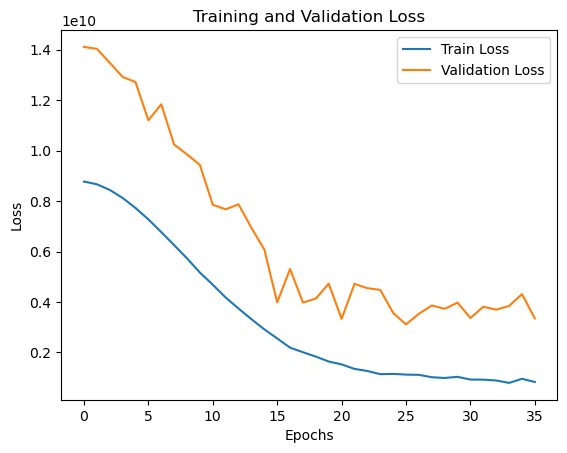

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [12]:
torch.save(
    model.state_dict(),
    os.path.join(os.getenv("WEIGHTS"), "ResNet.pth"),
)
print(f"Model saved")

Model saved
